In [80]:
import numpy as np
import sys
sys.path.append('..')
from data.smoothing import smooth_pend
from data.pendulum import pendulum_train_data, pendulum_test_data
from utils.normalize import normalize_pend
from data.pde_recovery import sample_idxs, load_and_shift_pend_data, optimal_recovery, rbf_vector_kernel, cross_validation, rhs, mse_loss, cross_validation_lengthscale, cross_validation_nugget
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

In [81]:
# Perform the PDE learning step for the pendulum data

I = 40  # Number of pendulums we're running
results, f = pendulum_train_data(I=I, noise=0.01)
test_results, f_test = pendulum_test_data(I=50, noise=0.01)

normalized_train_results, normalized_train_f, scalers = results, f, 8
normalized_test_results, normalized_test_f, test_scalers = test_results, f_test, 9

sample = sample_idxs()
S_train, f_train, t_train = load_and_shift_pend_data(normalized_train_results, normalized_train_f, sample, 15, .0001, kernel='poly')
S_test, f_test, t_test = load_and_shift_pend_data(normalized_test_results, normalized_test_f, sample, 15, .0001, kernel='poly')

In [82]:
for i in range(2):
    S_train[0,:,i,:] = minmax_scale(S_train[0,:,i,:])
    S_train[1,:,i,:] = minmax_scale(S_train[1,:,i,:])
    S_test[0,:,i,:] = minmax_scale(S_test[0,:,i,:])
    S_test[1,:,i,:] = minmax_scale(S_test[1,:,i,:])
f_train = minmax_scale(f_train)
f_test = minmax_scale(f_test)

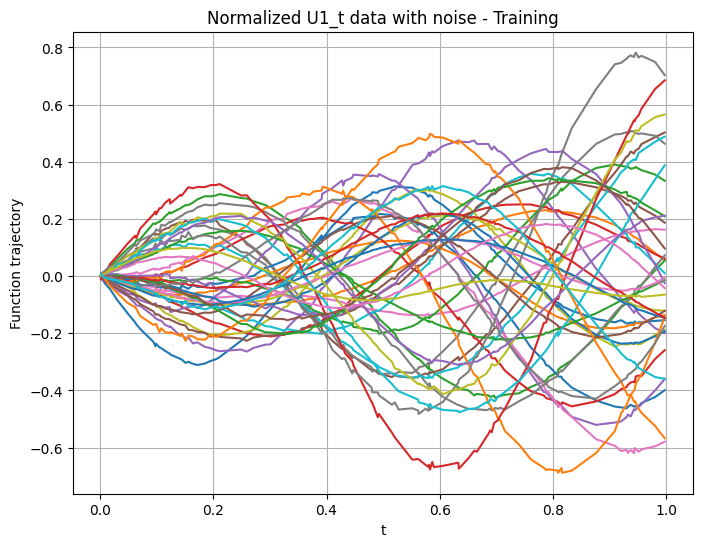

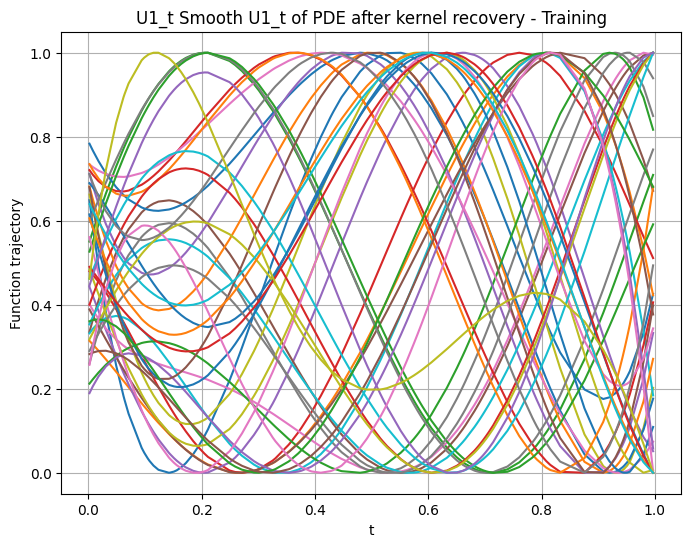

In [83]:
# Perform the PDE learning step for the pendulum data
plt.figure(figsize=(8, 6))

plt.plot(t_train, normalized_train_results[:, 1, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Normalized U1_t data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, S_train[1, :, 0, :])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Smooth U1_t of PDE after kernel recovery - Training')
plt.grid(True)
plt.show()

In [84]:
a_values = np.linspace(2, 5, 4) # the polynomial kernels we'll consider
print(a_values)

[2. 3. 4. 5.]


In [85]:
c_values_u1 = np.linspace(.01, 5, 100) # Chosen based on preliminary result of .1 (and subsequently .01) being best for a coarse search
nugget_values_u1 = np.linspace(1e-3, 1, 10) # Chosen based on preliminary result of .7 being best for a coarse search
# Cross validation with 2 varying params
print(S_train.shape)
print(S_train[1, :, 0, :].T.shape)
mse_surface_u1 = cross_validation(S_train[0, :, :2, :],  S_train[1, :, 0, :].T, c_values_u1, nugget_values_u1, a_values, kernel='poly')

(2, 101, 5, 40)
(40, 101)


Indices of the minimum value for a = 2.0: (99, 9)
c minimum value for a = 2.0: 5.0
nu minimum value for a = 2.0: 1.0
Minimum value for a = 2.0: 0.061755215525418426
Indices of the minimum value for a = 3.0: (99, 9)
c minimum value for a = 3.0: 5.0
nu minimum value for a = 3.0: 1.0
Minimum value for a = 3.0: 0.17516711684345793
Indices of the minimum value for a = 4.0: (99, 9)
c minimum value for a = 4.0: 5.0
nu minimum value for a = 4.0: 1.0
Minimum value for a = 4.0: 0.16716016086416174
Indices of the minimum value for a = 5.0: (99, 0)
c minimum value for a = 5.0: 5.0
nu minimum value for a = 5.0: 0.001
Minimum value for a = 5.0: 0.21757136593628798


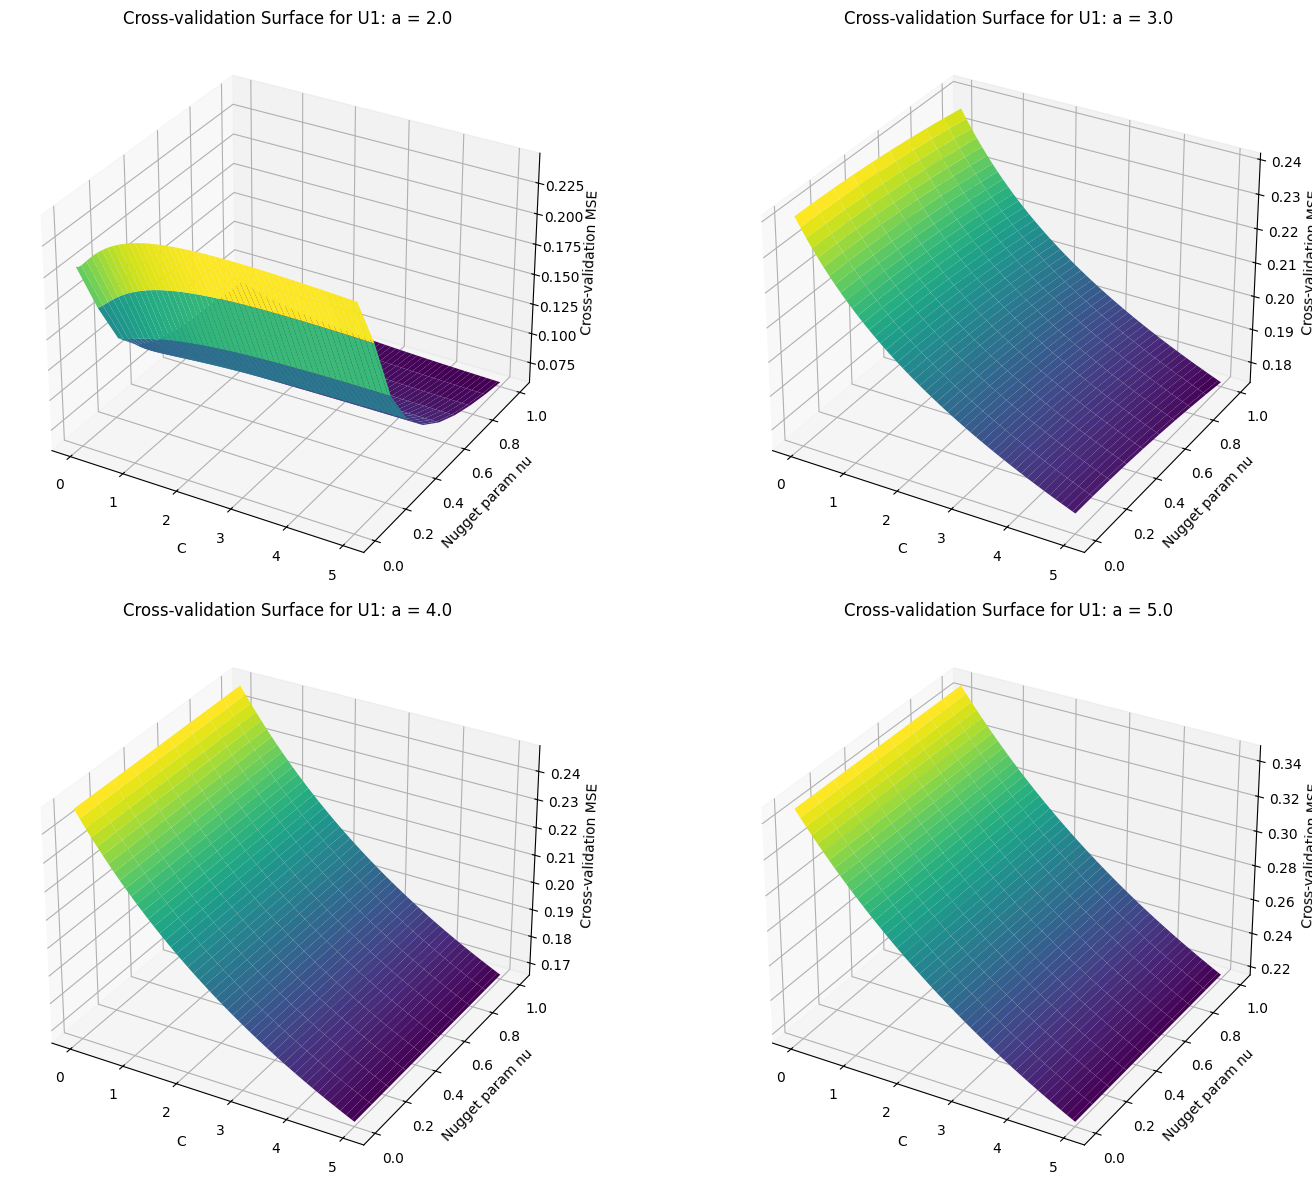

In [86]:
# Create a figure with subplots
fig = plt.figure(figsize=(16, 12))  # Adjust the figure size as needed
num_plots = len(a_values)
L1, L2 = np.meshgrid(c_values_u1, nugget_values_u1)

for idx, a in enumerate(a_values):
    ax = fig.add_subplot(2, (num_plots + 1) // 2, idx + 1, projection='3d')
    ax.plot_surface(L1, L2, mse_surface_u1[:, :, idx].T, cmap='viridis')
    ax.set_xlabel('C')
    ax.set_ylabel('Nugget param nu')
    ax.set_zlabel('Cross-validation MSE')
    ax.set_title(f'Cross-validation Surface for U1: a = {a}')

    min_index_u1 = np.unravel_index(np.argmin(mse_surface_u1[:, :, idx]), mse_surface_u1[:, :, idx].shape)
    print(f"Indices of the minimum value for a = {a}: {min_index_u1}")
    print(f"c minimum value for a = {a}: {c_values_u1[min_index_u1[0]]}")
    print(f"nu minimum value for a = {a}: {nugget_values_u1[min_index_u1[1]]}")
    print(f"Minimum value for a = {a}: {mse_surface_u1[:, :, idx][min_index_u1]}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [87]:
c_values_u2 = np.linspace(.01, 1, 100) # Chosen based on preliminary result of .1 (and subsequently .01) being best for a coarse search
nugget_values_u2 = np.linspace(1e-3, 1, 20) # Chosen based on preliminary result of .7 being best for a coarse search
mse_surface_u2 = cross_validation(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), c_values_u2, nugget_values_u2, a_values, kernel='poly')

Indices of the minimum value for a = 2.0: (99, 19)
c minimum value for a = 2.0: 1.0
nu minimum value for a = 2.0: 1.0
Minimum value for a = 2.0: 340.3944683399551
Indices of the minimum value for a = 3.0: (99, 19)
c minimum value for a = 3.0: 1.0
nu minimum value for a = 3.0: 1.0
Minimum value for a = 3.0: 319.42269141594335
Indices of the minimum value for a = 4.0: (99, 19)
c minimum value for a = 4.0: 1.0
nu minimum value for a = 4.0: 1.0
Minimum value for a = 4.0: 388.6130906167823
Indices of the minimum value for a = 5.0: (99, 19)
c minimum value for a = 5.0: 1.0
nu minimum value for a = 5.0: 1.0
Minimum value for a = 5.0: 436.172211849473


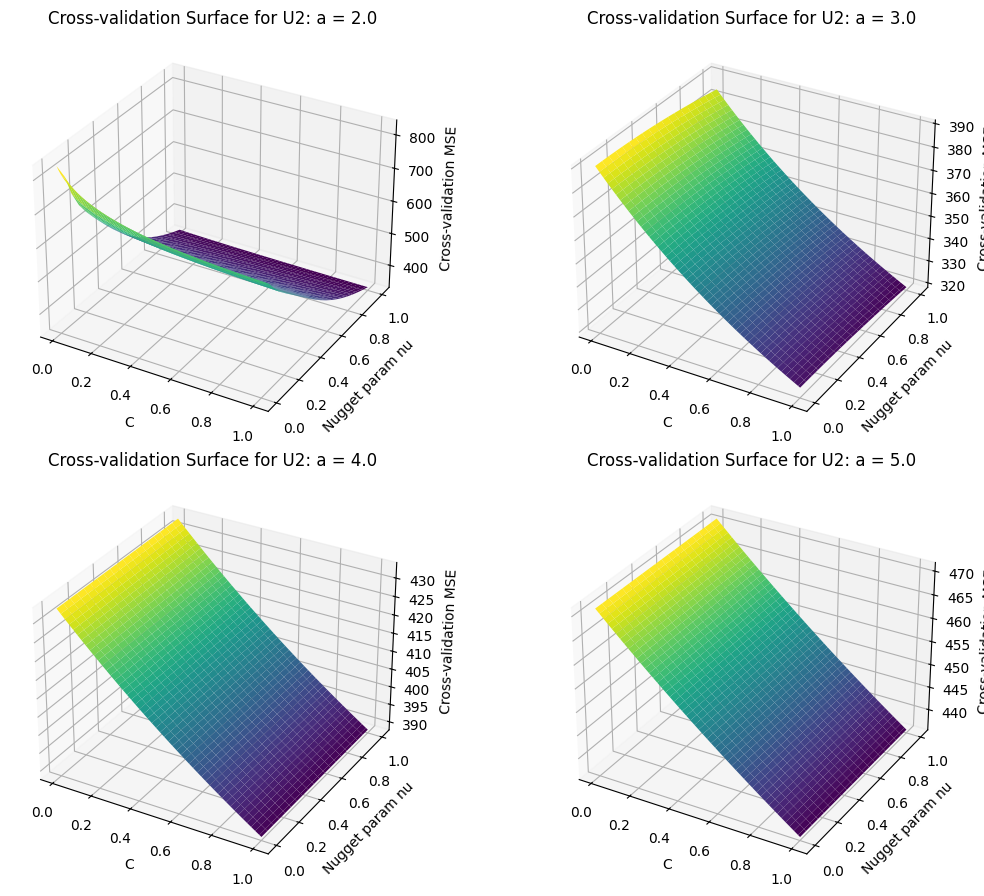

In [88]:
# Create a figure with subplots
fig = plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
num_plots = len(a_values)
L1, L2 = np.meshgrid(c_values_u2, nugget_values_u2)

for idx, a in enumerate(a_values):
    ax = fig.add_subplot(2, (num_plots + 1) // 2, idx + 1, projection='3d')
    ax.plot_surface(L1, L2, mse_surface_u2[:, :, idx].T, cmap='viridis')
    ax.set_xlabel('C')
    ax.set_ylabel('Nugget param nu')
    ax.set_zlabel('Cross-validation MSE')
    ax.set_title(f'Cross-validation Surface for U2: a = {a}')

    min_index_u2 = np.unravel_index(np.argmin(mse_surface_u2[:, :, idx]), mse_surface_u2[:, :, idx].shape)
    print(f"Indices of the minimum value for a = {a}: {min_index_u2}")
    print(f"c minimum value for a = {a}: {c_values_u2[min_index_u2[0]]}")
    print(f"nu minimum value for a = {a}: {nugget_values_u2[min_index_u2[1]]}")
    print(f"Minimum value for a = {a}: {mse_surface_u2[:, :, idx][min_index_u2]}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [89]:
P_hat1_train = optimal_recovery(S_train[0, :, :2, :], S_train[1, :, 0, :].T, S_train[0, :, :2, :], c_values_u1[min_index_u1[0]], nugget_values_u1[min_index_u1[1]], 3, ker='poly') #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat1 = optimal_recovery(S_train[0, :, :2, :], S_train[1, :, 0, :].T, S_test[0, :, :2, :], c_values_u1[min_index_u1[0]], nugget_values_u1[min_index_u1[1]], 3, ker='poly') #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat2_train = optimal_recovery(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), S_train[1, :, :2, :], c_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]], 3, ker='poly') #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat2 = optimal_recovery(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), S_test[1, :, :2, :], c_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]], 3, ker='poly') #P(rhs(train)) = u2  u2(test) = P(rhs(train)(test)

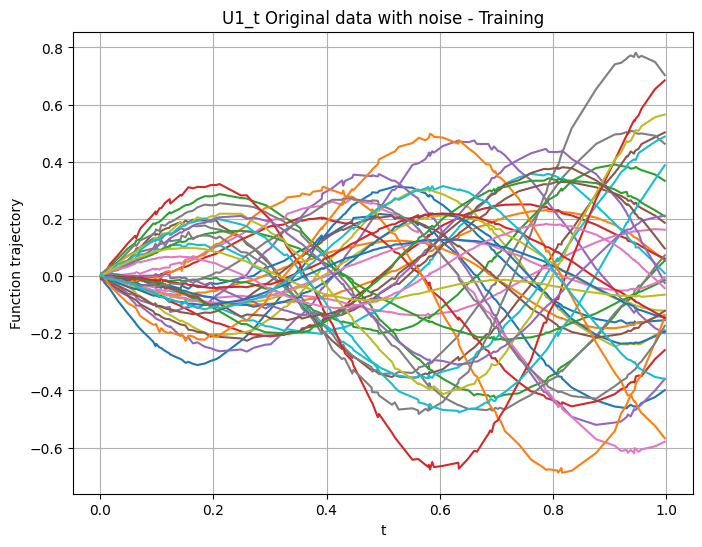

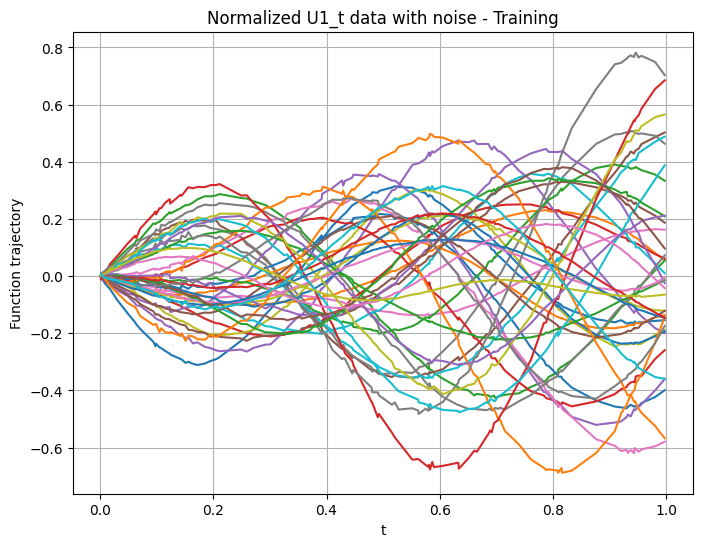

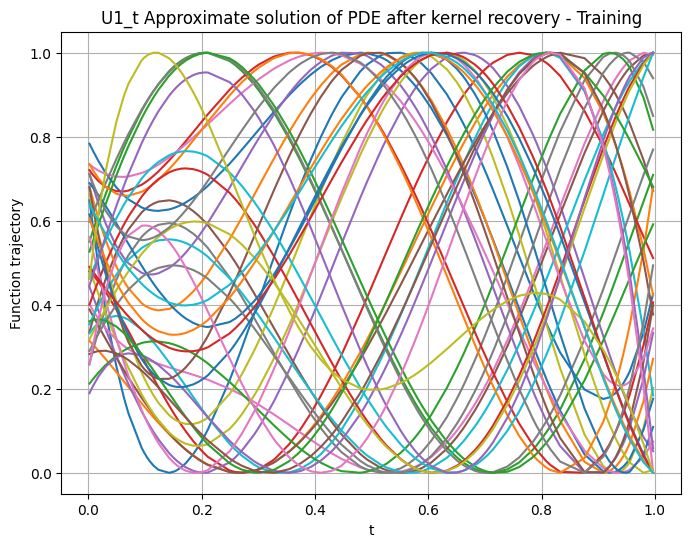

In [90]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Original data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, normalized_train_results[:, 1, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Normalized U1_t data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat1_train.T) #u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Approximate solution of PDE after kernel recovery - Training')
plt.grid(True)
plt.show()

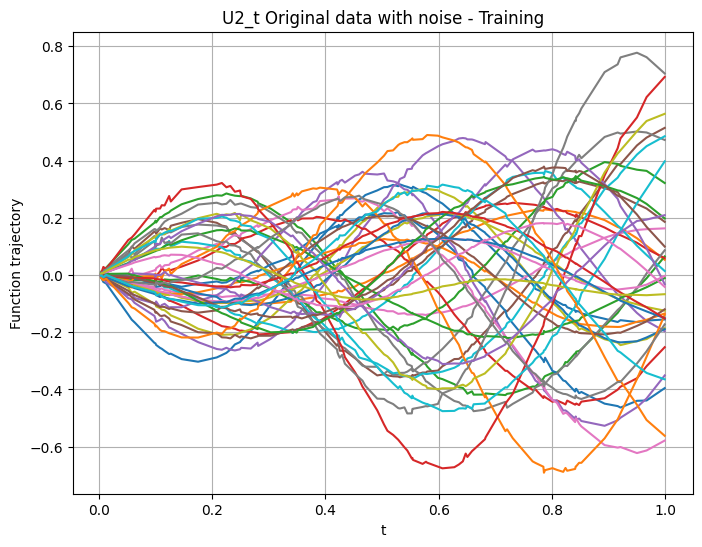

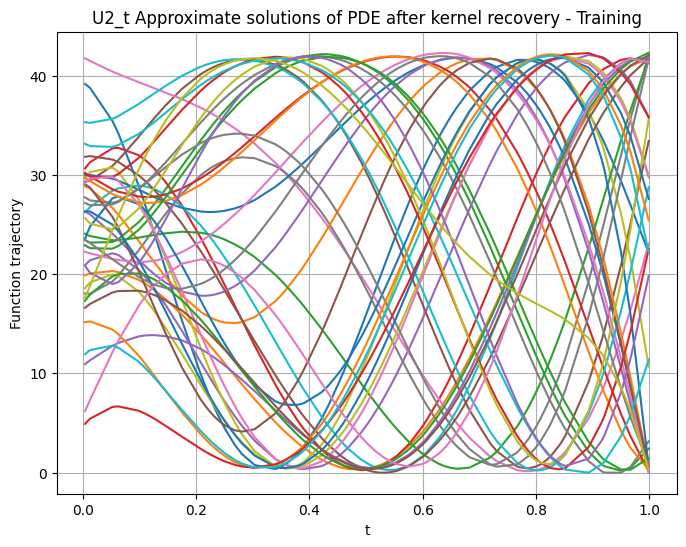

IndexError: index 52 is out of bounds for axis 3 with size 40

<Figure size 800x600 with 0 Axes>

In [72]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, normalized_train_results[:, 1, sample].T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Original data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat2_train.T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after kernel recovery - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, rhs(S_train[0,:,0,sample], normalized_train_f[:, sample]).T) # u1 
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t RHS using U1_t result - Training')
plt.grid(True)
plt.show()

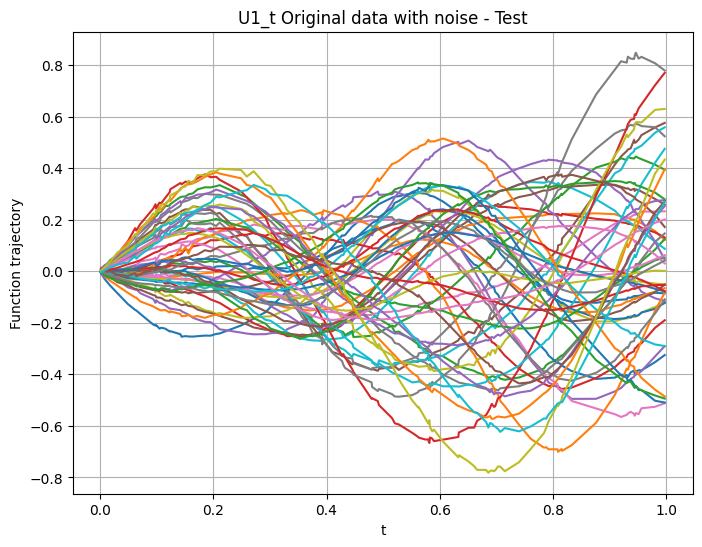

(2, 101, 5, 50)


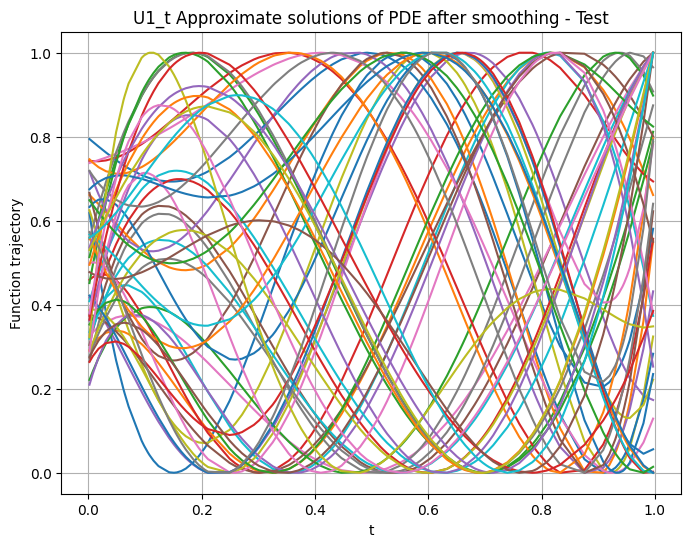

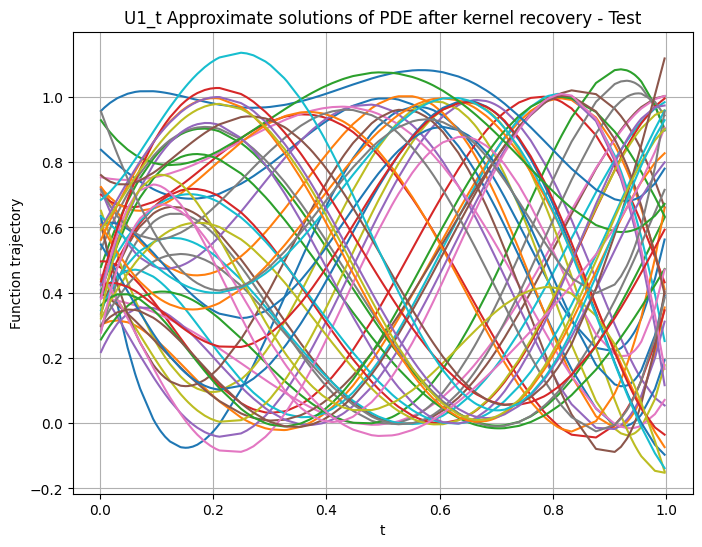

In [91]:
plt.figure(figsize=(8, 6))

plt.plot(t_test, test_results[:, 1, sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Original data with noise - Test')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, S_test[1, :, 0, :])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Approximate solutions of PDE after smoothing - Test')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, P_hat1.T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Approximate solutions of PDE after kernel recovery - Test')
plt.grid(True)
plt.show()

In [92]:
f_test.shape

(50, 101)

(2, 101, 5, 50)


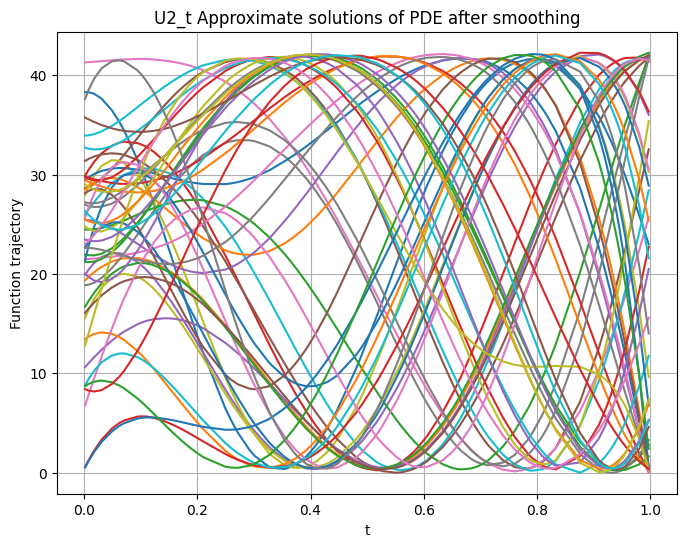

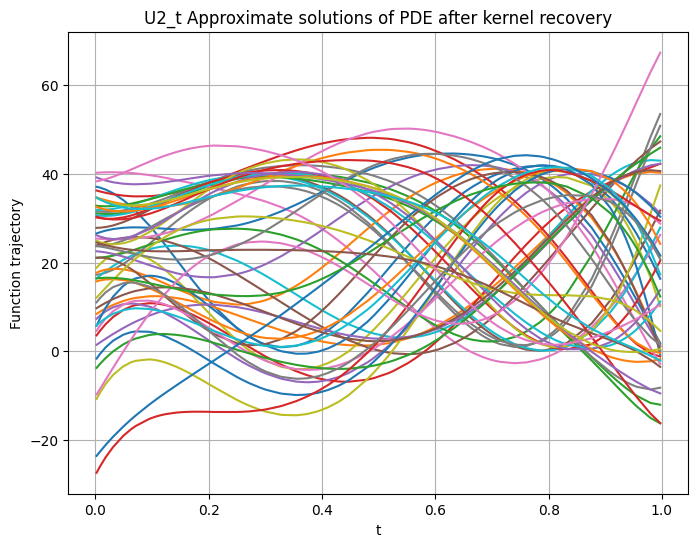

In [93]:
plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, rhs(S_test[0, :, 0, :].T, f_test[:,:]).T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after smoothing')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, P_hat2[:].T) # u2t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after kernel recovery')
plt.grid(True)
plt.show()

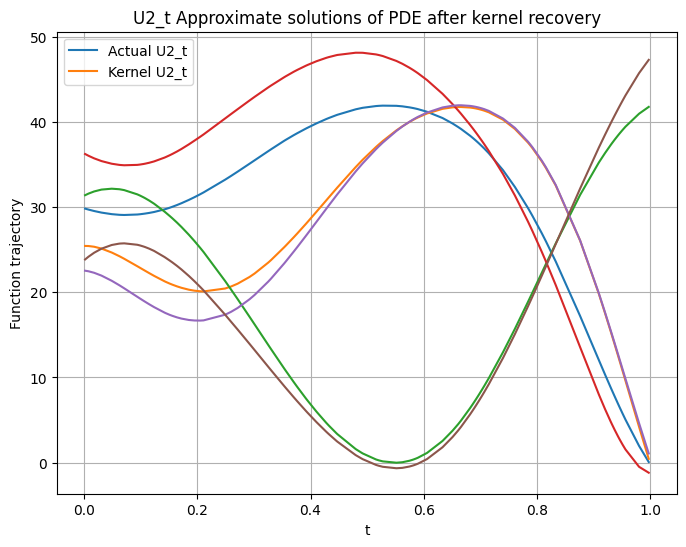

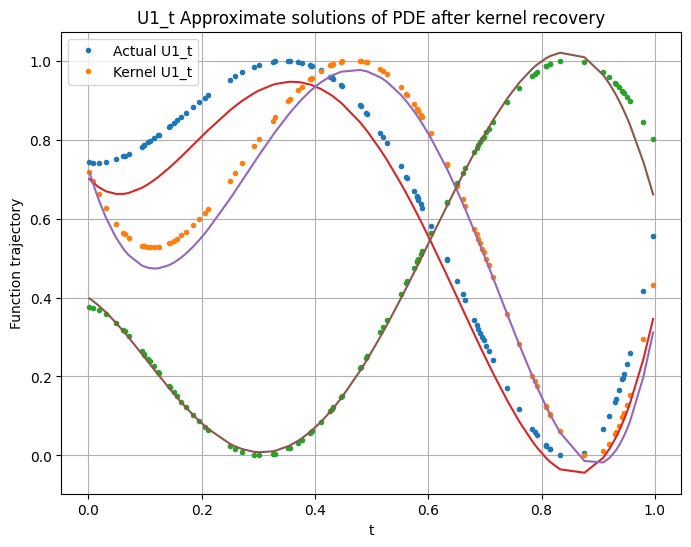

In [94]:
# Side by side the same signals
plt.figure(figsize=(8, 6))
plt.plot(t_test, rhs(S_test[0,:,0,13:16], f_test.T[:,13:16])) # u2
plt.plot(t_test, P_hat2[13:16].T) # u2t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Comparison of U2_t approximate solutions and actual solution')
plt.legend(['Actual U2_t', 'Kernel U2_t'])
plt.grid(True)

plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after kernel recovery')
plt.grid(True)
plt.show()


# Side by side the same signals
plt.figure(figsize=(8, 6))
plt.plot(t_test, S_test[1, :, 0, 13:16], '.') # u2
plt.plot(t_test, P_hat1[13:16].T) # u2t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Comparison of U1_t approximate solutions and actual solution')
plt.legend(['Actual U1_t', 'Kernel U1_t'])
plt.grid(True)

plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Approximate solutions of PDE after kernel recovery')
plt.grid(True)
plt.show()

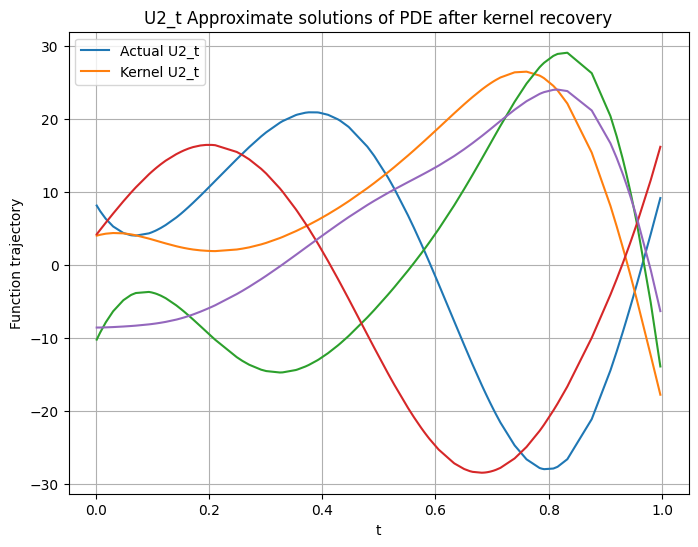

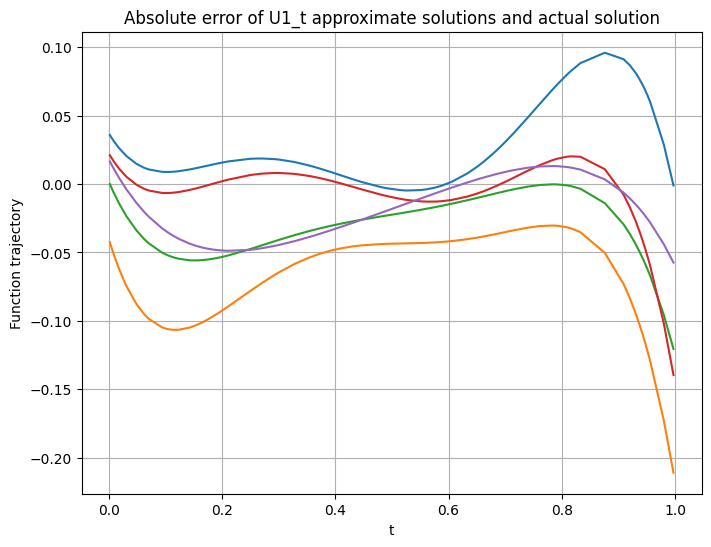

In [95]:
# Side by side the same signals
plt.figure(figsize=(8, 6))
plt.plot(t_test, P_hat2[12:17].T - rhs(P_hat1[12:17], S_test[0, :, 0, 12:17].T).T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Absolute error of U2_t approximate solutions and actual solution')
plt.legend(['Actual U2_t', 'Kernel U2_t'])
plt.grid(True)

plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after kernel recovery')
plt.grid(True)
plt.show()


# Side by side the same signals
plt.figure(figsize=(8, 6))
plt.plot(t_test, P_hat1[12:17].T - S_test[1, :, 0, 12:17]) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Absolute error of U1_t approximate solutions and actual solution')
plt.grid(True)

In [97]:

print(mean_squared_error(P_hat1.T, S_test[1, :, 0, :]))
print(mean_squared_error(P_hat2.T, rhs(S_test[0,:,0,:], f_test.T)))


0.009478251000464242
45.83275972768001
